# Qubit Optimization for 3-qubit Ising model 

We will be comparing the PennyLane gradient descent optimizer with the optimizers in Tensorflow and PyTorch for this quantum system. The Ising model is an example of a system whose optimization landscape is non-convex and hence using gradient descent may not be the best strategy since the optimization can get stuck in local minimas. Quantum annealing (for example on a D-wave system) is one alternative that may have more success in finding the global ground state. 

The energy for this system is given by:
$$ H=-\sum_{<i,j>} J_{ij} \sigma_i \sigma_{j}$$

where each spin can be in +1 or -1 spin state and $J_{ij}$ are nearest neighbour coupling strengths.

For simplicity, we will assume that the first spin is always in up state (+1 eigenstate of Pauli-Z operator)

# PennyLane optimizer

In [1]:
# import PennyLane library

import pennylane as qml
from pennylane import numpy as np

In [2]:
# create our three devices. 

dev1 = qml.device('default.qubit', wires = 3)
dev2 = qml.device('default.qubit', wires = 3)
dev3 = qml.device('default.qubit', wires = 3)

In [3]:
# We use PennyLane's Rot(phi,theta,omega,wires) single-qubit operation

@qml.qnode(dev1)
def circuit1(p1, p2):
    qml.Rot(p1[0], p1[1], p1[2], wires = 1)
    qml.Rot(p2[0], p2[1], p2[2], wires = 2)
    return qml.expval.PauliZ(0), qml.expval.PauliZ(1), qml.expval.PauliZ(2) 

# the expectation value of Pauli-Z is +1 for spin up and -1 for spin down.

Our cost function is the energy of the spin configuration which we will optimize using gradient descent.

Let the coupling matrix be J = [1,-1]

In [4]:
def cost1(var):
    spins = circuit1(var[0], var[1])
    energy = -(1*spins[0]*spins[1]) - (-1*spins[1]*spins[2])
    return energy

Let's test these functions for the [1,-1,-1] spin configuration. 

Total energy for this Ising model should be

$$H = -1(J_1 s_1 \otimes s_2 + J_2 s_2 \otimes s3) = -1 [1 \times 1 \times (-1) + (-1) \times (-1) \times (-1)] = 2 $$


In [5]:
# You can easily guess the angles if you look at the Rot(phi,theta,omega)

t1 = np.array([0, np.pi, 0])    #spin 2 in -1 state
t2 = np.array([0, np.pi ,0])     #spin 3 in -1 state
print(cost1([t1, t2]))

2.0


Now we optimize using the PennyLane gradient descent optimizer

In [173]:
# initialize the parameters to some random values
np.random.seed(48)
pl1 = np.pi*(np.random.ranf(3))
pl2 = np.pi*(np.random.ranf(3))
var_init = np.array([pl1, pl2])
cost_init = cost1(var_init)
print(cost_init)

1.6909756656963444


The minimun energy should be -2 for the [1,1,-1] spin configuration which corresponds to the angles of [0,0,0] and [0,pi,0] for second and third spin respectively. 

In [174]:
gd = qml.GradientDescentOptimizer(0.4)

var = var_init
var_gd = [var]
cost_gd = [cost_init]

for it in range(100):
    var = gd.step(cost1, var)
    if (it + 1) % 5 == 0:
        var_gd.append(var)
        cost_gd.append (cost1(var))
        print('Energy after step {:5d}: {: .7f} | Angles: {}'.format(it + 1, cost1(var), var),"\n")

Energy after step     5: -0.8526522 | Angles: [[0.05494731 0.82939429 0.89491775]
 [0.93926199 1.83649654 1.01935445]] 

Energy after step    10: -1.9846264 | Angles: [[0.05494731 0.00311615 0.89491775]
 [0.93926199 2.96607366 1.01935445]] 

Energy after step    15: -1.9999059 | Angles: [[5.49473067e-02 1.04553176e-06 8.94917751e-01]
 [9.39261991e-01 3.12787147e+00 1.01935445e+00]] 

Energy after step    20: -1.9999994 | Angles: [[5.49473067e-02 3.34668166e-10 8.94917751e-01]
 [9.39261991e-01 3.14052566e+00 1.01935445e+00]] 

Energy after step    25: -2.0000000 | Angles: [[5.49473067e-02 1.07387285e-13 8.94917751e-01]
 [9.39261991e-01 3.14150968e+00 1.01935445e+00]] 

Energy after step    30: -2.0000000 | Angles: [[ 5.49473067e-02 -2.12409211e-17  8.94917751e-01]
 [ 9.39261991e-01  3.14158620e+00  1.01935445e+00]] 

Energy after step    35: -2.0000000 | Angles: [[ 5.49473067e-02 -2.12409211e-17  8.94917751e-01]
 [ 9.39261991e-01  3.14159215e+00  1.01935445e+00]] 

Energy after step    

# TensorFlow optimizer

In [175]:
# activate tenserflow 
import tensorflow as tf
import tensorflow.contrib.eager as tfe

# to suppress warnings from being printed
tf.logging.set_verbosity(tf.logging.ERROR)

# check if the eager tenserflow execution is working
tf.enable_eager_execution()
print(tf.executing_eagerly())

True


In [176]:
@qml.qnode(dev2, interface = 'tfe')
def circuit2(p1, p2):
        qml.Rot(p1[0], p1[1], p1[2], wires = 1)
        qml.Rot(p2[0], p2[1], p2[2], wires = 2)
        return qml.expval.PauliZ(0), qml.expval.PauliZ(1), qml.expval.PauliZ(2)

In [177]:
def cost2(var):
    spins = circuit2(var[0], var[1])
    energy = -(1*spins[0]*spins[1]) - (-1*spins[1]*spins[2])
    return energy

In [178]:
# let's test the functions for our known spin configuration [1,-1,-1]

t1 = tfe.Variable([0, np.pi, 0], dtype = tf.float64)
t2 = tfe.Variable([0, np.pi, 0], dtype = tf.float64)

print(cost2([t1, t2]))

tf.Tensor(2.0, shape=(), dtype=float64)


In [179]:
# initialize the parameters to some random values
tf.random.set_random_seed(21)
tf1 = tfe.Variable(tf.random_uniform([3], 0, np.pi, dtype = tf.float64))
tf2 = tfe.Variable(tf.random_uniform([3], 0, np.pi, dtype = tf.float64))
var_init = [tf1, tf2]
cost_init = cost2(var_init)
print(cost_init)

tf.Tensor(1.7860905782632743, shape=(), dtype=float64)


In [180]:
# optimize using tensorflow optimizer

opt = tf.train.GradientDescentOptimizer(learning_rate=0.1)


var = var_init
var_tf = [var]
cost_tf = [cost_init]

for i in range(100):
    with tf.GradientTape() as tape:
        loss = cost2([tf1, tf2])
        grads = tape.gradient(loss, [tf1, tf2])

    opt.apply_gradients(zip(grads, [tf1, tf2]), global_step=tf.train.get_or_create_global_step())
    if (i + 1) % 5 == 0:
            var_tf.append([tf1,tf2])
            cost_tf.append (cost2([tf1,tf2]))
            print('Energy after step {:5d}: {: .7f} | Angles: {}'.format(i+1,cost2([tf1,tf2]), [tf1.numpy(),tf2.numpy()]),"\n")

Energy after step     5:  0.9352332 | Angles: [array([0.62509959, 2.05809012, 1.7676818 ]), array([0.77132251, 3.06881248, 0.88720477])] 

Energy after step    10: -0.9022222 | Angles: [array([0.62509959, 1.10204233, 1.7676818 ]), array([0.77132251, 3.06490224, 0.88720477])] 

Energy after step    15: -1.8315440 | Angles: [array([0.62509959, 0.41173165, 1.7676818 ]), array([0.77132251, 3.08802801, 0.88720477])] 

Energy after step    20: -1.9806325 | Angles: [array([0.62509959, 0.13739658, 1.7676818 ]), array([0.77132251, 3.10920994, 0.88720477])] 

Energy after step    25: -1.9977809 | Angles: [array([0.62509959, 0.0451202 , 1.7676818 ]), array([0.77132251, 3.12241992, 0.88720477])] 

Energy after step    30: -1.9997172 | Angles: [array([0.62509959, 0.01478926, 1.7676818 ]), array([0.77132251, 3.13026791, 0.88720477])] 

Energy after step    35: -1.9999542 | Angles: [array([0.62509959, 0.00484639, 1.7676818 ]), array([0.77132251, 3.13490525, 0.88720477])] 

Energy after step    40: -1

# PyTorch optimizer

In [181]:
import torch
from torch.autograd import Variable

In [182]:
@qml.qnode(dev3, interface = 'torch')
def circuit3(p1, p2):
    qml.Rot(p1[0], p1[1], p1[2], wires = 1)
    qml.Rot(p2[0], p2[1], p2[2], wires = 2)
    return qml.expval.PauliZ(0), qml.expval.PauliZ(1), qml.expval.PauliZ(2) 

In [183]:
def cost3(var1,var2):
    spins = circuit3(var1, var2)
    energy = -(1*spins[0]*spins[1]) - (-1*spins[1]*spins[2])
    return energy

In [184]:
# let's test the functions for our known spin configuration [1,-1,-1]

t1=torch.tensor([0, np.pi, 0])
t2=torch.tensor([0, np.pi ,0])
print(cost3(t1, t2))

tensor(2.0000, dtype=torch.float64)


In [185]:
torch.manual_seed(56)
pt1 = Variable((np.pi*torch.rand(3, dtype = torch.float64)), requires_grad = True)
pt2 = Variable((np.pi*torch.rand(3, dtype = torch.float64)), requires_grad = True)
var_init = [pt1, pt2]
cost_init = cost3(pt1, pt2)
print(cost_init)

tensor(1.6792, dtype=torch.float64, grad_fn=<SubBackward0>)


In [186]:
# optimizing using PyTorch optimizer 

opt = torch.optim.SGD(var_init, lr = 0.1)

def closure():
    opt.zero_grad()
    loss = cost3(pt1, pt2)
    loss.backward()
    return loss


var_pt = [var_init]
cost_pt = [cost_init]

for j in range(100):
    opt.step(closure)
    if (j + 1) % 5 == 0:
        pt1, pt2 = opt.param_groups[0]['params']
        costn = cost3(pt1, pt2)
        var_pt.append([pt1,pt2])
        cost_pt.append(costn)
        print('Energy after step {:5d}: {: .7f} | Angles: {}'.format(j+1,costn, [pt1.detach().numpy(), pt2.detach().numpy()]),"\n")

Energy after step     5:  0.6846474 | Angles: [array([1.96323939, 1.93604492, 2.32767565]), array([0.65212549, 2.73080219, 2.4299563 ])] 

Energy after step    10: -1.0138530 | Angles: [array([1.96323939, 1.0136468 , 2.32767565]), array([0.65212549, 2.73225282, 2.4299563 ])] 

Energy after step    15: -1.8171995 | Angles: [array([1.96323939, 0.38483073, 2.32767565]), array([0.65212549, 2.85992571, 2.4299563 ])] 

Energy after step    20: -1.9686584 | Angles: [array([1.96323939, 0.13026452, 2.32767565]), array([0.65212549, 2.97097572, 2.4299563 ])] 

Energy after step    25: -1.9930403 | Angles: [array([1.96323939, 0.04302756, 2.32767565]), array([0.65212549, 3.04042222, 2.4299563 ])] 

Energy after step    30: -1.9980133 | Angles: [array([1.96323939, 0.01413292, 2.32767565]), array([0.65212549, 3.08179844, 2.4299563 ])] 

Energy after step    35: -1.9993550 | Angles: [array([1.96323939, 0.00463472, 2.32767565]), array([0.65212549, 3.10627578, 2.4299563 ])] 

Energy after step    40: -1

In [187]:
import matplotlib.pyplot as plt
%matplotlib inline

In [188]:
x = [0]
for k in range(100):
    if (k + 1) % 5 == 0:
        x.append(k)

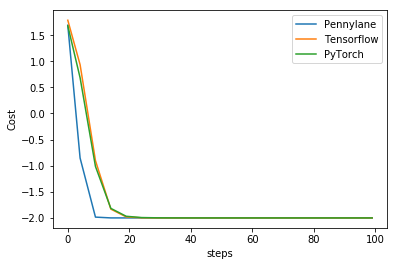

In [189]:
plt.plot(x, cost_gd, label = 'Pennylane')
plt.plot(x, cost_tf, label = 'Tensorflow')
plt.plot(x, cost_pt, label = 'PyTorch')
plt.xlabel("steps")
plt.ylabel("Cost")
plt.legend()
plt.show()

**So far, `random seeds` were set so that all the optimizers could find global minima.**

With different random intialization for the optimizers, in some runs, you should see one or more of the optimizers getting stuck in a local minima of energy (usually zero energy). 

Let's have a look at one such instance below.